# Data Notebook
This notebook documents the data produced for the paper titled "Photonic Down Conversion Mediated by Excited State Vibrational Polaritons".
The 'twa_model.py' provides the functional code for modeling excited state vibrational polaritons using the truncated Wigner Approximation (TWA). As described in the paper the, TWA for harmonic systems such as the one being modeled here is exact. The model  is essentially just an evaluation of analytical expressions for occupation values. The only numerical calculations is for the eigenvalue decomposition of the Hessian matrix that gives the uncoupled polariton modes and their frequencies

In [ ]:
import twa_model as twa
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

def plot_params():
    plt.gca().spines['left'].set_linewidth(2)
    plt.gca().spines['bottom'].set_linewidth(2)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xlabel('time / ps', fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylabel(r'$\langle N_{x} \rangle$', fontsize=20)
    plt.xticks(fontsize=16)
    plt.gca().xaxis.set_tick_params(width=2)
    plt.gca().yaxis.set_tick_params(width=2)
    legend = plt.legend(title='$x = $', loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, fontsize=16)
    legend.get_title().set_fontsize('20')


## Isolated System
The 'parameters' dictionary stores all relevant parameters for the model. Below the field and bath sizes are set two zero so that the cavity-vibration system is isolated from any environment.

In [75]:
k2eV = 4.55633e-6  # converts wavenumbers (cm-1) to atomic units (A.U.)
def set_param():
    p = {'cavity freq': 1600 * k2eV,  # (cm-1) -> (A.U.)
                  'vibration freq': 1600 * k2eV,  # (cm-1) -> (A.U.)
                  'Huang-Rhys': 0.75,
                  'coupling': 0.04e-3,  # (A.U)
                  'final time': 10,  # (ps)
                  'time steps': 4000,
                  'field size': 0,
                  'bath size': 0,
                  'res range': 878 * k2eV,  # (cm-1) -> (A.U.)
                  'vibration lifetime': 2,  # (ps)
                  'Q': 1600  # Cavity quality factor
                  }
    return p
parameters = set_param()

## 'twa_model.py' Functions
* **'polariton_modes'** calculates the polariton modes and frequencies.

* **'pol_displacement'** calculates the potential minumum along each polariton mode.
* **'oc_dynamics'** calculates the time evolved occupation values for the different subsystems determined by the 'subsystem' argument which can be either 'cavity', 'vibration', 'field or 'bath'.

Below the cavity and vibration occupation values are calculated for the isolated system.

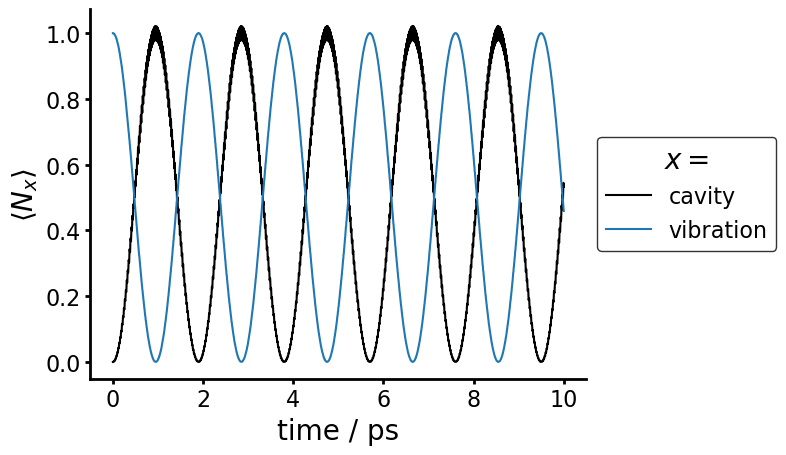

In [12]:
polEn, polStates, siteEn = twa.polariton_modes(parameters)
polDispl = twa.pol_displacement(parameters, polEn, polStates, siteEn)
nCav = twa.oc_dynamics(parameters, polEn, polStates, siteEn, polDispl, subsystem='cavity')
nVib = twa.oc_dynamics(parameters, polEn, polStates, siteEn, polDispl, subsystem='vibration')

plt.plot(nCav[0], nCav[1], label='cavity', color='k')
plt.plot(nVib[0], nVib[1], label='vibration', color='tab:blue')
plot_params()

It should be noted that vibration occupation value is calculated in the shifted basis based on the excited state potential. The shifted raising and lowering operators are related to the unshifted (ground state) operators as
$$\tilde{a}^\dagger =  a^\dagger + \sqrt{S}\\ \tilde{a} = a + \sqrt{S} $$
and the vibration number operator in the shifted basis is given by
$$ N_\textrm{vib} = a^\dagger a + \sqrt{S}(a^\dagger + a) + S $$
where $S$ is the Huang-Rhys factor. $N_\textrm{vib}$ can then be transformed in terms of the position operator $Q$ by $Q = \sqrt{\hbar/2 \omega_v} (a^\dagger + a)$.

## Coupling to Harmonic Baths
The reservoir of external electromagnetic fields and solvent vibrations are included in the model by setting the number of field and bath modes to 500.

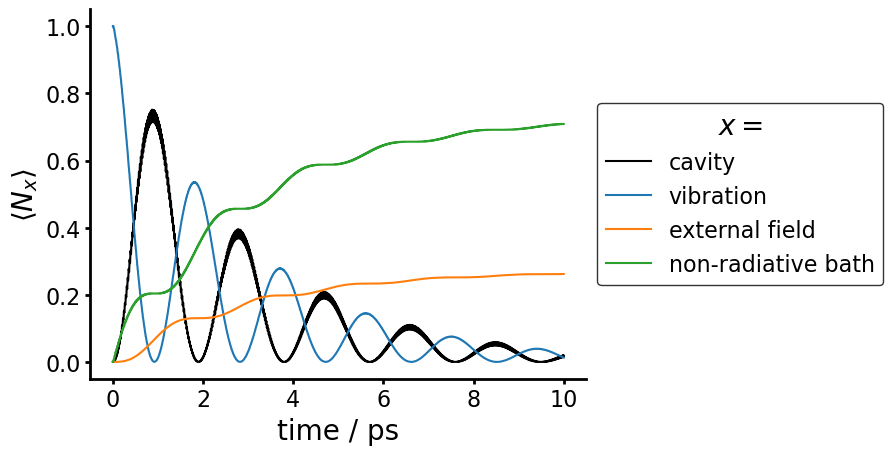

In [13]:
parameters = set_param()
parameters['field size'] = 500
parameters['bath size'] = 500

polEn, polStates, siteEn = twa.polariton_modes(parameters)
polDispl = twa.pol_displacement(parameters, polEn, polStates, siteEn)

nCav = twa.oc_dynamics(parameters, polEn, polStates, siteEn, polDispl, subsystem='cavity')
nVib = twa.oc_dynamics(parameters, polEn, polStates, siteEn, polDispl, subsystem='vibration')
nField = twa.oc_dynamics(parameters, polEn, polStates, siteEn, polDispl, subsystem='field')
nBath = twa.oc_dynamics(parameters, polEn, polStates, siteEn, polDispl, subsystem='bath')

plt.plot(nCav[0], nCav[1], label='cavity', color='k')
plt.plot(nVib[0], nVib[1], label='vibration', color='tab:blue')
plt.plot(nField[0], nField[1], label='external field', color='tab:orange')
plt.plot(nBath[0], nBath[1], label='non-radiative bath', color='tab:green')
plot_params()

## Isolated Cavity-Vibration System Parameter Space (Figure 3)
Figure 1 studies the parameter space of an isolated cavity-vibration system. Specifically it looks at the maximum number of photons as a function of the cavity-vibration (Jaynes-Cumming) coupling strength ($g$).

Below shows $\langle N_\textrm{vib} \rangle$ at $S = 0.75$ for different $g$ values.

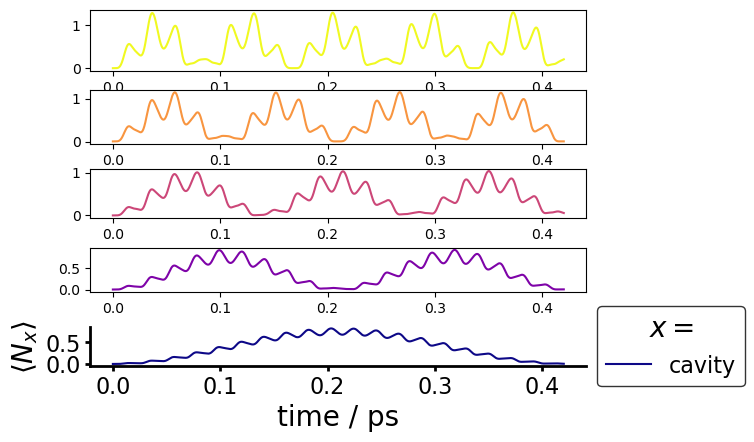

In [14]:
parameters = set_param()
# isolated system:
parameters['field size'] = 0
parameters['bath size'] = 0
# shorten time to capture strong coupling oscillations
parameters['final time'] = 0.42

parameters['Huang-Rhys'] = 0.75

gRange = np.linspace(0.18e-3, 0.9e-3, 5)
nCavOut = np.zeros((gRange.size + 1, parameters['time steps']))
colors = plt.cm.plasma(np.linspace(0, 1, gRange.size))
fig, axs = plt.subplots(gRange.size)
for i, g in enumerate(gRange):
    parameters['coupling'] = g
    polEn, polStates, siteEn = twa.polariton_modes(parameters)
    polDispl = twa.pol_displacement(parameters, polEn, polStates, siteEn)
    nCav = twa.oc_dynamics(parameters, polEn, polStates, siteEn, polDispl, subsystem='cavity')
    if i == 0:
        nCavOut[i] = nCav[0]
        nCavOut[i + 1] =  nCav[1]
    else:
        nCavOut[i + 1] = nCav[1]
    axs[gRange.size - 1 - i].plot(nCav[0], nCav[1], label='cavity', color=colors[i])
    axs[gRange.size - 1 - i].set_aspect(0.04)
    plot_params()

In [15]:
np.savetxt('data/g_stacked_ncav.txt', nCavOut)

Below shows the calculation of the $g$ vs $S$ heatmap.

In [16]:
parameters['time steps'] = 8000
parameters['final time'] = 48.3778

gRange = np.linspace(0.01e-3, 1e-3, 100)
sRange = np.linspace(0, 1, 100)
nCavMax = np.zeros((gRange.size, sRange.size))
for i, g in enumerate(gRange):
    for j, s in enumerate(sRange):
        parameters['coupling'] = g
        parameters['Huang-Rhys'] = s
        polEn, polStates, siteEn = twa.polariton_modes(parameters)
        polDispl = twa.pol_displacement(parameters, polEn, polStates, siteEn)
        nCav = twa.oc_dynamics(parameters, polEn, polStates, siteEn, polDispl, subsystem='cavity')
        nCavMax[i, j] = np.max(nCav[1])

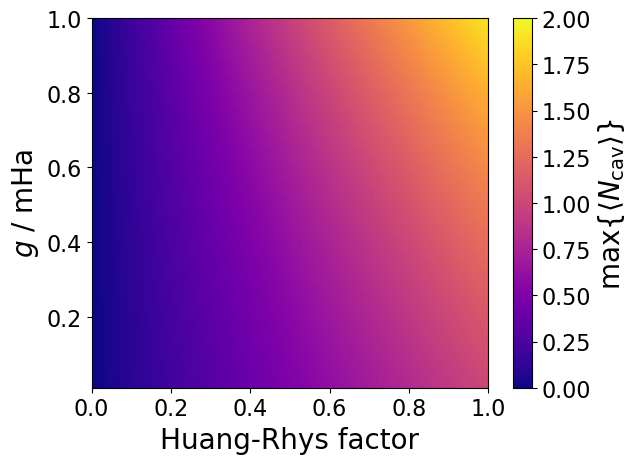

In [17]:
plt.imshow(nCavMax, cmap='plasma', aspect='auto', extent=[sRange[0], sRange[-1], gRange[0] * 1000, gRange[-1] * 1000], origin='lower', vmin=0, vmax=np.round(nCavMax[-1, -1] + 0.05, 1))
plt.ylabel(r'$g$ / mHa', fontsize=20)
plt.xlabel(r'Huang-Rhys factor', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
cbar = plt.colorbar()
cbar.set_label(label=r'max{$\langle N_\mathrm{cav} \rangle$}', size=20)
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(16)

In [18]:
np.savetxt('data/g_vs_S_nCavMax.txt', nCavMax)

## Vibrational Polaritons Coupled to Reservoirs (Figure 4)
Below show dynamics for three different Quality factors. The vibrational lifetime is fixed at 2 ps for each calculation.
## **Q = 16**:

In [ ]:
parameters = set_param()
parameters['Q'] = 16
parameters['field size'] = 500
parameters['bath size'] = 500
parameters['final time'] = 12

polEn, polStates, siteEn = twa.polariton_modes(parameters)
polDispl = twa.pol_displacement(parameters, polEn, polStates, siteEn)

nCav = twa.oc_dynamics(parameters, polEn, polStates, siteEn, polDispl, subsystem='cavity')
nVib = twa.oc_dynamics(parameters, polEn, polStates, siteEn, polDispl, subsystem='vibration')
nField = twa.oc_dynamics(parameters, polEn, polStates, siteEn, polDispl, subsystem='field')
nBath = twa.oc_dynamics(parameters, polEn, polStates, siteEn, polDispl, subsystem='bath')

plt.plot(nCav[0], nCav[1], label='cavity', color='k')
plt.plot(nVib[0], nVib[1], label='vibration', color='tab:blue')
plt.plot(nField[0], nField[1], label='external field', color='tab:orange')
plt.plot(nBath[0], nBath[1], label='non-radiative bath', color='tab:green')
plot_params()

save data to text file

In [20]:
Qout_16 = np.zeros((5, parameters['time steps']))
Qout_16[0] = nCav[0]  # first row is time
Qout_16[1] = nCav[1]  # second row is cavity occupation
Qout_16[2] = nVib[1]  # vibration occupation
Qout_16[3] = nField[1]  # field occupation
Qout_16[4] = nBath[1]  # bath occupation
np.savetxt('data/Qout_16.txt', Qout_16)

## **Q = 100**:

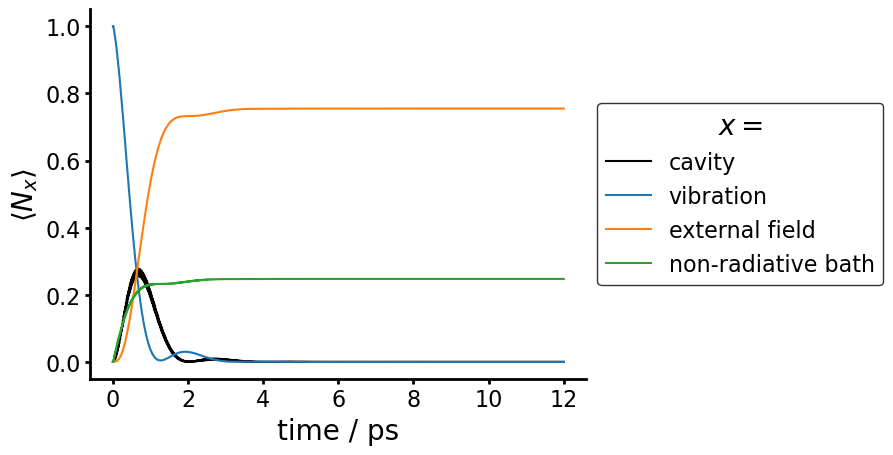

In [21]:
parameters['Q'] = 100

polEn, polStates, siteEn = twa.polariton_modes(parameters)
polDispl = twa.pol_displacement(parameters, polEn, polStates, siteEn)

nCav = twa.oc_dynamics(parameters, polEn, polStates, siteEn, polDispl, subsystem='cavity')
nVib = twa.oc_dynamics(parameters, polEn, polStates, siteEn, polDispl, subsystem='vibration')
nField = twa.oc_dynamics(parameters, polEn, polStates, siteEn, polDispl, subsystem='field')
nBath = twa.oc_dynamics(parameters, polEn, polStates, siteEn, polDispl, subsystem='bath')

plt.plot(nCav[0], nCav[1], label='cavity', color='k')
plt.plot(nVib[0], nVib[1], label='vibration', color='tab:blue')
plt.plot(nField[0], nField[1], label='external field', color='tab:orange')
plt.plot(nBath[0], nBath[1], label='non-radiative bath', color='tab:green')
plot_params()

In [22]:
Qout_100 = np.zeros((5, parameters['time steps']))
Qout_100[0] = nCav[0]  # first row is time
Qout_100[1] = nCav[1]  # second row is cavity occupation
Qout_100[2] = nVib[1]  # vibration occupation
Qout_100[3] = nField[1]  # field occupation
Qout_100[4] = nBath[1]  # bath occupation
np.savetxt('data/Qout_16.txt', Qout_100)

## **Q=1600**:

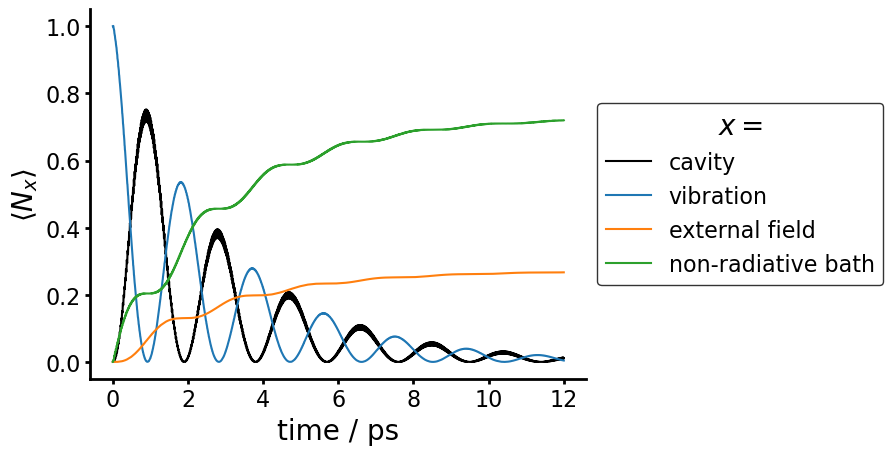

In [23]:
parameters['Q'] = 1600

polEn, polStates, siteEn = twa.polariton_modes(parameters)
polDispl = twa.pol_displacement(parameters, polEn, polStates, siteEn)

nCav = twa.oc_dynamics(parameters, polEn, polStates, siteEn, polDispl, subsystem='cavity')
nVib = twa.oc_dynamics(parameters, polEn, polStates, siteEn, polDispl, subsystem='vibration')
nField = twa.oc_dynamics(parameters, polEn, polStates, siteEn, polDispl, subsystem='field')
nBath = twa.oc_dynamics(parameters, polEn, polStates, siteEn, polDispl, subsystem='bath')

plt.plot(nCav[0], nCav[1], label='cavity', color='k')
plt.plot(nVib[0], nVib[1], label='vibration', color='tab:blue')
plt.plot(nField[0], nField[1], label='external field', color='tab:orange')
plt.plot(nBath[0], nBath[1], label='non-radiative bath', color='tab:green')
plot_params()

In [24]:
Qout_1600 = np.zeros((5, parameters['time steps']))
Qout_1600[0] = nCav[0]  # first row is time
Qout_1600[1] = nCav[1]  # second row is cavity occupation
Qout_1600[2] = nVib[1]  # vibration occupation
Qout_1600[3] = nField[1]  # field occupation
Qout_1600[4] = nBath[1]  # bath occupation
np.savetxt('data/Qout_1600.txt', Qout_1600)

## Q vs $g$
Here shows the percentage of photonic emission as a function of the coupling strenght ($g$) and the quality factor (Q). The data set for the higher quality image used in the paper is provided in the data folder.

In [62]:
parameters = set_param()
parameters['field size'] = 500
parameters['bath size'] = 500
parameters['time steps'] = 2
parameters['final time'] = 18

QrangeSqrt = np.linspace(2, 80, 30)
# Converts quality factor into the cavity external field coupling factor kappa
# cavity-vibration coupling values
gRange = np.linspace(1e-8, 0.1e-03, 30)

percEmiss = np.zeros((gRange.size, QrangeSqrt.size))
for i, Qsqrt in enumerate(QrangeSqrt):
    for j, g in enumerate(gRange):
        parameters['coupling'] = g
        parameters['Q'] = Qsqrt ** 2
        polEn, polStates, siteEn = twa.polariton_modes(parameters)
        polDispl = twa.pol_displacement(parameters, polEn, polStates, siteEn)
        nField = twa.oc_dynamics(parameters, polEn, polStates, siteEn, polDispl, subsystem='field')
        percEmiss[j, i] = nField[1][1]/parameters['Huang-Rhys'] * 100

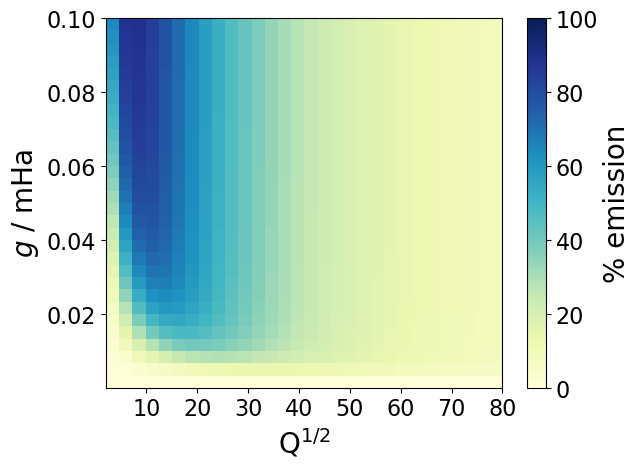

In [65]:
plt.ylabel(r'$g$ / mHa', fontsize=20)
plt.xlabel(r'$\mathrm{Q}^{1/2}$', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.imshow(percEmiss, extent=[QrangeSqrt[0], QrangeSqrt[-1], gRange[0] * 1e3, gRange[-1] * 1e3], cmap='YlGnBu',
           aspect='auto', origin='lower',vmin=0, vmax=100)
cbar = plt.colorbar()
cbar.set_label(label='% emission', size=20)
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(16)

## **G vs Q slices**

In [68]:
s = 0.00125e-3
gRange = []
for i in range(7):
    gRange = np.append(gRange, s)
    s = s * 2

QrangeSqrt = np.linspace(2, 80, 100)

percEmissSlice = np.zeros((gRange.size, QrangeSqrt.size))

for j, g in enumerate(gRange):
    for i, Qsqrt in enumerate(QrangeSqrt):
        parameters['coupling'] = g
        parameters['Q'] = Qsqrt ** 2
        polEn, polStates, siteEn = twa.polariton_modes(parameters)
        polDispl = twa.pol_displacement(parameters, polEn, polStates, siteEn)
        nField = twa.oc_dynamics(parameters, polEn, polStates, siteEn, polDispl, subsystem='field')
        percEmissSlice[j, i] = nField[1][1]/parameters['Huang-Rhys'] * 100

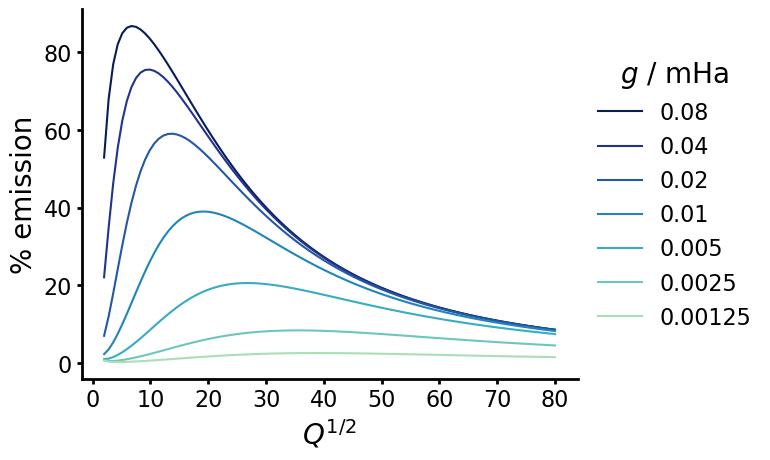

In [97]:
colors = plt.cm.YlGnBu(np.linspace(0.3, 1, gRange.size))
for j, g in enumerate(np.flip(gRange)):
    plt.plot(QrangeSqrt, percEmissSlice[gRange.size - j - 1, :], label=str(g * 1e3), color=colors[gRange.size - j - 1])
plot_params()
plt.xlabel(r'$Q^{1/2}$', fontsize=20)
plt.ylabel(r'% emission', fontsize=20)
legend = plt.legend(title='$g$ / mHa', loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, fontsize=16)
legend.get_title().set_fontsize('20')
legend.get_frame().set_edgecolor('black')
plt.savefig('g_vs_Q_slices.png', dpi=300, bbox_inches='tight')

## Cavity Frequency Dependent Dynamics for and Isolated System

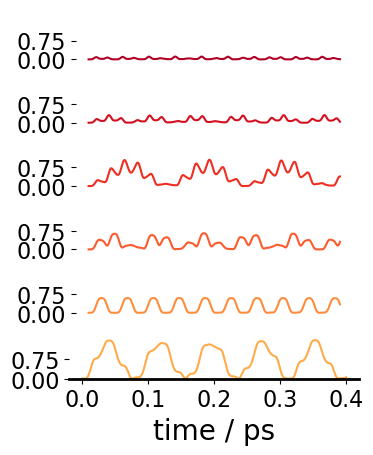

In [98]:
parameters = set_param()
parameters['coupling'] = 0.6e-3
parameters['final time'] = 0.4

freqRange = np.linspace(450, 2400, 6) * k2eV
fig, axs = plt.subplots(freqRange.size)
colors = plt.cm.YlOrRd(np.linspace(0.4, 1, gRange.size))
for i, freq in enumerate(freqRange):
    parameters['cavity freq'] = freq
    polEn, polStates, siteEn = twa.polariton_modes(parameters)
    polDispl = twa.pol_displacement(parameters, polEn, polStates, siteEn)
    nCav = twa.oc_dynamics(parameters, polEn, polStates, siteEn, polDispl, subsystem='cavity')
    axs[freqRange.size - 1 - i].plot(nCav[0], nCav[1], color=colors[i])
    axs[freqRange.size - 1 - i].spines['bottom'].set_linewidth(2)
    axs[freqRange.size - 1 - i].spines['top'].set_visible(False)
    axs[freqRange.size - 1 - i].spines['right'].set_visible(False)
    axs[freqRange.size - 1 - i].spines['left'].set_visible(False)
    axs[freqRange.size - 1 - i].set_yticks([0, parameters['Huang-Rhys']])
    axs[freqRange.size - 1 - i].set_aspect(0.04)
    axs[freqRange.size - 1 - i].tick_params(axis='y', which='major', labelsize=16)
    if i == 0:
        axs[freqRange.size - 1 - i].set_ylim(0, 2)
    else:
        axs[freqRange.size - 1 - i].set_ylim(-0.1, 2)
        axs[freqRange.size - 1 - i].spines['bottom'].set_visible(False)
        axs[freqRange.size - 1 - i].tick_params(bottom=False)
        axs[freqRange.size - 1 - i].xaxis.set_ticklabels([])
plt.xlabel('time / ps', fontsize=20)
plt.xticks(fontsize=16)
plt.savefig('freq_dep_dynamics.png', dpi=300, bbox_inches='tight')